In [1]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error


In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('./passenger.csv', usecols=[1],
skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """


In [3]:
dataframe.shape

(144, 1)

In [4]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
       a = dataset[i:(i+look_back), 0]
       dataX.append(a)
       dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [5]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [7]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [8]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
# create and fit the LSTM network
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, GRU
from keras.optimizers import RMSprop, Adam
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"
model = Sequential()
model.add(LSTM(15, input_shape=(1, look_back)))
# model.add(LSTM(3, input_shape=(1, look_back)))
# model.add(LSTM(3))
# model.add(GRU(5, input_shape=(1, look_back)))
model.add(Dense(1, activation='linear'))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.add(Dense(1))
# optimizer = RMSprop(lr=0.001)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-08)

# model.compile(loss='binary_crossentropy', optimizer='adam')
model.compile(loss='binary_crossentropy', optimizer=optimizer)

model.summary()


ValueError: Input 0 is incompatible with layer lstm_8: expected ndim=3, found ndim=2

In [ ]:
model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [12]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [13]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.45 RMSE
Test Score: 55.80 RMSE


In [14]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
#trainPredictPlot = trainPredict

In [15]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
#testPredictPlot[len(trainPredict):, :] = testPredict

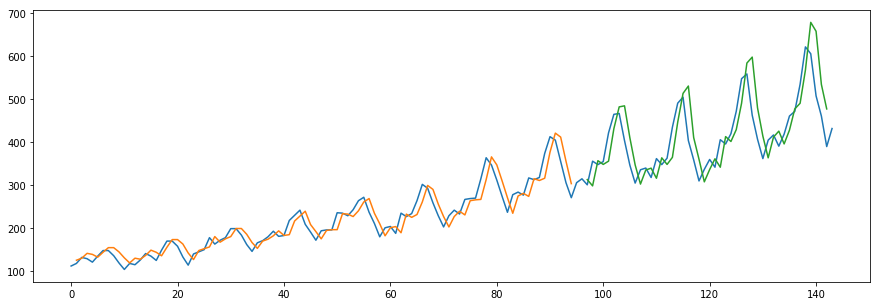

In [16]:
# plot baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.show()